In [1]:
!pip install pennylane qiskit qiskit-aer qiskit-aqua qiskit-ibmq-provider qiskit-ignis qiskit-machine-learning qiskit-terra

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 11.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 35.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.4/240.4 KB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.7/198.7 KB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.8/152.8 KB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 74.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.3/55.3 KB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.0/107.0 KB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 KB

In [2]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer
import matplotlib.pyplot as plt
import random
from sklearn.datasets import make_blobs

dataset_list = []

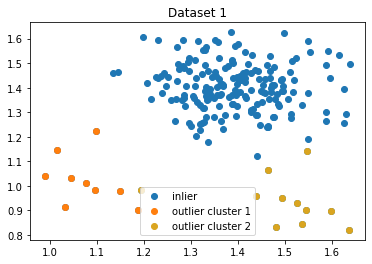

In [3]:
random.seed(13)
seed = 0
x, y = make_blobs(n_samples=190, centers=1, cluster_std=.1, center_box=(1.4, 1.4), random_state=seed)

out1x, out1y = make_blobs(n_samples=9, centers=1, cluster_std=.1, center_box=(1, 1), random_state=seed)
out2x, out2y = make_blobs(n_samples=11, centers=1, cluster_std=.1, center_box=(3.2, 0.01), random_state=seed)

plt.show()

# prepare data for One-Class model
y[y == 0] = 1
out1y[out1y==0] = -1 
out2y[out2y==0] = -1 

x = np.append(x, out1x, axis = 0)
y = np.append(y, out1y, axis = 0)

x = np.append(x, out2x, axis = 0)
y = np.append(y, out2y, axis = 0)

# Plot to see data
plt.scatter(x[:,0], x[:,1], label='inlier')
plt.scatter(out1x[:,0], out1x[:,1], label='outlier cluster 1')
plt.scatter(out2x[:,0], out2x[:,1], label='outlier cluster 2', color='goldenrod')

plt.title('Dataset 1')
plt.legend()
plt.show()

# Add data to dataset_list
dataset_list.append([x,y])

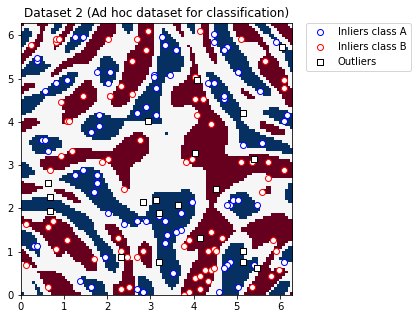

In [4]:
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.datasets import ad_hoc_data
adhoc_dimension = 2
train_features, train_labels, test_features, test_labels, adhoc_total = ad_hoc_data(
    training_size=80,
    test_size=0,
    n=adhoc_dimension,
    gap=0.3,
    plot_data=False,
    one_hot=False,
    include_sample_total=True,
)
train_features_out, train_labels_out, _, _ = ad_hoc_data(
    training_size=10,
    test_size=0,
    n=adhoc_dimension,
    gap=0.6,
    plot_data=False,
    one_hot=False,
    include_sample_total=False,
)
# adhoc_total[adhoc_total == 0] = 1

# print(train_features)
# print(train_labels)

# Change labels for One-Class
train_labels_out[train_labels_out != -1] = -1

# Now we have to add the outliers
train_features = np.append(train_features, train_features_out, axis = 0)
train_labels = np.append(train_labels, train_labels_out, axis = 0)


plt.figure(figsize=(5, 5))
plt.ylim(0, 2 * np.pi)
plt.xlim(0, 2 * np.pi)
plt.imshow(
    np.asmatrix(adhoc_total).T,
    interpolation="nearest",
    origin="lower",
    cmap="RdBu",
    extent=[0, 2 * np.pi, 0, 2 * np.pi],
)

plt.scatter(
    train_features[np.where(train_labels[:] == 0), 0],
    train_features[np.where(train_labels[:] == 0), 1],
    marker="o",
    facecolors="w",
    edgecolors="b",
    label="Inliers class A",
)
plt.scatter(
    train_features[np.where(train_labels[:] == 1), 0],
    train_features[np.where(train_labels[:] == 1), 1],
    marker="o",
    facecolors="w",
    edgecolors="r",
    label="Inliers class B",
)
plt.scatter(
    train_features[np.where(train_labels[:] == -1), 0],
    train_features[np.where(train_labels[:] == -1), 1],
    marker="s",
    facecolors="w",
    edgecolors="k",
    label="Outliers",
)


plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
plt.title("Dataset 2 (Ad hoc dataset for classification)")

plt.show()

# We don't need the second label for one-class SVMs, so change 0 label to 1
train_labels[train_labels == 0] = 1


# add data to dataset_list
dataset_list.append([train_features,train_labels])

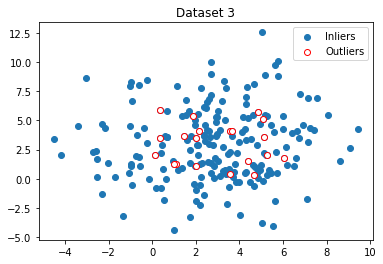

In [5]:
# Third dataset, create blob and add zz feature map data to it
random.seed(13)
seed = 23
x, y = make_blobs(n_samples=190, centers=1, cluster_std=3, center_box=(3, 3), random_state=seed)
train_features_out2, train_labels_out2, _, _ = ad_hoc_data(
    training_size=10,
    test_size=0,
    n=adhoc_dimension,
    gap=0.5,
    plot_data=False,
    one_hot=False,
    include_sample_total=False,
)

# prepare data for One-Class model
y[y == 0] = 1
train_labels_out2[train_labels_out2 != -1] = -1 

# add outliers to data
x = np.append(x, train_features_out2, axis = 0)
y = np.append(y, train_labels_out2, axis = 0)

# Plot to see data
plt.scatter(x[:,0], x[:,1], label='Inliers')
plt.scatter(
    train_features_out2[np.where(train_labels_out2[:] == -1), 0],
    train_features_out2[np.where(train_labels_out2[:] == -1), 1],
    marker="o",
    facecolors="w",
    edgecolors="r",
    label="Outliers",
)

plt.title('Dataset 3')
plt.legend()
plt.show()

# Add data to dataset_list
dataset_list.append([x,y])

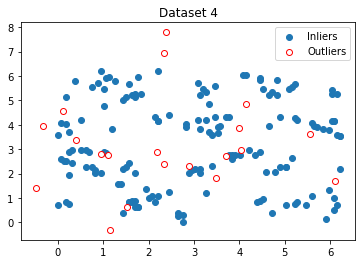

In [6]:
adhoc_dimension = 2
train_features, train_labels, _,_ = ad_hoc_data(
    training_size=80,
    test_size=0,
    n=adhoc_dimension,
    gap=0.6,
    plot_data=False,
    one_hot=False,
    include_sample_total=False,
)
x, y = make_blobs(n_samples=20, centers=3, cluster_std=2, center_box=(3, 3), random_state=111)

# prepare data for One-Class model
train_labels[train_labels == 0] = 1
y[y != -1] = -1 

# add outliers to data
train_features = np.append(train_features, x, axis = 0)
train_labels = np.append(train_labels, y, axis = 0)

# Plot to see data
plt.scatter(
    train_features[np.where(train_labels[:] == 1), 0],
    train_features[np.where(train_labels[:] == 1), 1],
    #marker="o",
    #facecolors="w",
    #edgecolors="b",
    label="Inliers",
)
plt.scatter(
    x[np.where(y[:] == -1), 0],
    x[np.where(y[:] == -1), 1],
    marker="o",
    facecolors="w",
    edgecolors="r",
    label="Outliers"
)

plt.title('Dataset 4')
plt.legend()
plt.show()

# Add data to dataset_list
dataset_list.append([train_features,train_labels])

In [7]:
dev = qml.device("default.qubit", wires=2)

In [8]:
def get_angles(x):

    beta0 = 2 * np.arcsin(np.sqrt(x[1] ** 2) / np.sqrt(x[0] ** 2 + x[1] ** 2 + 1e-12))
    beta1 = 2 * np.arcsin(np.sqrt(x[3] ** 2) / np.sqrt(x[2] ** 2 + x[3] ** 2 + 1e-12))
    beta2 = 2 * np.arcsin(
        np.sqrt(x[2] ** 2 + x[3] ** 2)
        / np.sqrt(x[0] ** 2 + x[1] ** 2 + x[2] ** 2 + x[3] ** 2)
    )

    return np.array([beta2, -beta1 / 2, beta1 / 2, -beta0 / 2, beta0 / 2])


def statepreparation(a):
    qml.RY(a[0], wires=0)

    qml.CNOT(wires=[0, 1])
    qml.RY(a[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[2], wires=1)

    qml.PauliX(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[3], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[4], wires=1)
    qml.PauliX(wires=0)

In [9]:
def layer(W):
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.CNOT(wires=[0, 1])

In [10]:
@qml.qnode(dev)
def circuit(weights, angles):
    statepreparation(angles)

    for W in weights:
        layer(W)

    return qml.expval(qml.PauliZ(0))

def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

def accuracy(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

    return loss


def variational_classifier(weights, bias, angles):
    return circuit(weights, angles) + bias


def cost(weights, bias, features, labels):
    predictions = [variational_classifier(weights, bias, f) for f in features]
    return square_loss(labels, predictions)


In [11]:
def dataset(data):
  # for X, Y in data:
    # X = data[:, 0:2]
    X = data[0]
    # print("First X sample (original)  :", X[0])

    # pad the vectors to size 2^2 with constant values
    padding = 0.3 * np.ones((len(X), 1))
    X_pad = np.c_[np.c_[X, padding], np.zeros((len(X), 1))]
    # print("First X sample (padded)    :", X_pad[0])

    # normalize each input
    normalization = np.sqrt(np.sum(X_pad ** 2, -1))
    X_norm = (X_pad.T / normalization).T
    # print("First X sample (normalized):", X_norm[0])

    # angles for state preparation are new features
    features = np.array([get_angles(x) for x in X_norm], requires_grad=False)
    # print("First features sample      :", features[0])

    Y = data[1]

    np.random.seed(0)
    num_data = len(Y)
    num_train = int(0.75 * num_data)
    index = np.random.permutation(range(num_data))
    feats_train = features[index[:num_train]]
    Y_train = Y[index[:num_train]]
    feats_val = features[index[num_train:]]
    Y_val = Y[index[num_train:]]

    # We need these later for plotting
    X_train = X[index[:num_train]]
    X_val = X[index[num_train:]]

    return X, Y, features, num_train, feats_train, Y_train, feats_val, Y_val, X_train, X_val

In [35]:
from sklearn.metrics import f1_score
def trainer(X, Y, features, num_train, feats_train, Y_train, feats_val, Y_val, X_train, X_val, num_layers, num_steps):
  num_qubits = 2
  # num_layers = 6

  weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
  bias_init = np.array(0.0, requires_grad=True)
  opt = NesterovMomentumOptimizer(0.01)
  batch_size = 5

  # train the variational classifier
  weights = weights_init
  bias = bias_init
  for it in range(num_steps):

      # Update the weights by one optimizer step
      batch_index = np.random.randint(0, num_train, (batch_size,))
      feats_train_batch = feats_train[batch_index]
      Y_train_batch = Y_train[batch_index]
      weights, bias, _, _ = opt.step(cost, weights, bias, feats_train_batch, Y_train_batch)

      # Compute predictions on train and validation set
      predictions_train = [np.sign(variational_classifier(weights, bias, f)) for f in feats_train]
      predictions_val = [np.sign(variational_classifier(weights, bias, f)) for f in feats_val]

      # Compute accuracy on train and validation set
      acc_train = accuracy(Y_train, predictions_train)
      acc_val = accuracy(Y_val, predictions_val)
      f1_train = f1_score(Y_train, predictions_train , average='binary')
      f1_val = f1_score(Y_val, predictions_val, average='binary' )

  print(
      "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} | F1 Train: {:0.7f} | F1 val: {:0.7f}"
      "".format(it + 1, cost(weights, bias, features, Y), acc_train, acc_val, f1_train, f1_val)
  )

  # plt.figure()
  # cm = plt.cm.RdBu

  # # make data for decision regions
  # xx, yy = np.meshgrid(np.linspace(a, b ,c), np.linspace(d, e, f))
  # X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]

  # # preprocess grid points like data inputs above
  # padding = 0.3 * np.ones((len(X_grid), 1))
  # X_grid = np.c_[np.c_[X_grid, padding], np.zeros((len(X_grid), 1))]  # pad each input
  # normalization = np.sqrt(np.sum(X_grid ** 2, -1))
  # X_grid = (X_grid.T / normalization).T  # normalize each input
  # features_grid = np.array(
  #     [get_angles(x) for x in X_grid]
  # )  # angles for state preparation are new features
  # predictions_grid = [variational_classifier(weights, bias, f) for f in features_grid]
  # Z = np.reshape(predictions_grid, xx.shape)
  #   # plot decision regions
  # cnt = plt.contourf(xx, yy, Z, levels=np.arange(-1, 1.1, 0.1), cmap=cm, alpha=0.8, extend="both")
  # plt.contour(xx, yy, Z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,))
  # plt.colorbar(cnt, ticks=[-1, 0, 1])

  # # plot data
  # plt.scatter(
  #     X_train[:, 0][Y_train == 1],
  #     X_train[:, 1][Y_train == 1],
  #     c="b",
  #     marker="o",
  #     edgecolors="k",
  #     label="class 1 train",
  # )
  # plt.scatter(
  #     X_val[:, 0][Y_val == 1],
  #     X_val[:, 1][Y_val == 1],
  #     c="b",
  #     marker="^",
  #     edgecolors="k",
  #     label="class 1 validation",
  # )
  # plt.scatter(
  #     X_train[:, 0][Y_train == -1],
  #     X_train[:, 1][Y_train == -1],
  #     c="r",
  #     marker="o",
  #     edgecolors="k",
  #     label="class -1 train",
  # )
  # plt.scatter(
  #     X_val[:, 0][Y_val == -1],
  #     X_val[:, 1][Y_val == -1],
  #     c="r",
  #     marker="^",
  #     edgecolors="k",
  #     label="class -1 validation",
  # )

  # plt.legend()
  # plt.show()

  





In [37]:
for i in range(0,4):
  X, Y, features, num_train, feats_train, Y_train, feats_val, Y_val, X_train, X_val = dataset(dataset_list[i])
  print("For dataset: {}".format(i+1))
  for j in range(1,7):
    print("Expermient with no. of layers : {}".format(j))
    trainer(X, Y, features, num_train, feats_train, Y_train, feats_val, Y_val, X_train, X_val, j, 5)

For dataset: 1
Expermient with no. of layers : 1
Iter:     5 | Cost: 0.3474441 | Acc train: 0.9108280 | Acc validation: 0.8867925 | F1 Train: 0.9533333 | F1 val: 0.9400000
Expermient with no. of layers : 2
Iter:     5 | Cost: 0.3470499 | Acc train: 0.9108280 | Acc validation: 0.8867925 | F1 Train: 0.9533333 | F1 val: 0.9400000
Expermient with no. of layers : 3
Iter:     5 | Cost: 0.3621906 | Acc train: 0.9108280 | Acc validation: 0.8867925 | F1 Train: 0.9533333 | F1 val: 0.9400000
Expermient with no. of layers : 4
Iter:     5 | Cost: 0.3436088 | Acc train: 0.9108280 | Acc validation: 0.8867925 | F1 Train: 0.9533333 | F1 val: 0.9400000
Expermient with no. of layers : 5
Iter:     5 | Cost: 0.3401900 | Acc train: 0.9108280 | Acc validation: 0.8867925 | F1 Train: 0.9533333 | F1 val: 0.9400000
Expermient with no. of layers : 6
Iter:     5 | Cost: 0.3543393 | Acc train: 0.9108280 | Acc validation: 0.8867925 | F1 Train: 0.9533333 | F1 val: 0.9400000
For dataset: 2
Expermient with no. of layer